# Plotting the weather data 

- Running in the 24hr environment kernel 
- Functions are built on from 24hr weather script

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In this project I have converted all the metadata to UTC so should be comparable to the weather data without needing to change timezones

In [2]:
def read_and_process_csv(file_path):
    # Read the CSV file
    df = pd.read_csv(file_path)
    
    # Rename the specified column
    df.rename(columns={'Timestamp (UTC+0)': 'date_time'}, inplace=True)
    
    # Convert the date column to datetime format
    df['date_time'] = pd.to_datetime(df['date_time'])
    
    return df

# Run the function for all the data
ten_min_23 = read_and_process_csv('../metadata/2023/10min_Oct22_Aug23_weather.csv')
daily_23 = read_and_process_csv('../metadata/2023/Daily_Oct22_Aug23_weather.csv')
hourly_23 = read_and_process_csv('../metadata/2023/Hourly_Oct22_Aug23_weather.csv')

ten_min_24 = read_and_process_csv('../metadata/2024/10_min.csv')
hourly_24 = read_and_process_csv('../metadata/2024/Hourly.csv')
daily_24 = read_and_process_csv('../metadata/2024/Daily.csv')

#Concatenate the different years
ten_min = pd.concat([ten_min_23, ten_min_24])
hourly = pd.concat([hourly_23, hourly_24])
daily = pd.concat([daily_23, daily_24])

# Convert the date columns to datetime format with error handling
daily['AirTC_TMn'] = pd.to_datetime(daily['AirTC_TMn'], errors='coerce', format='%d/%m/%Y %H:%M')
daily['AirTC_TMx'] = pd.to_datetime(daily['AirTC_TMx'], errors='coerce', format='%d/%m/%Y %H:%M')

/var/folders/ns/9skdzql508n7rzzgbqpc2wpw000f7r/T/ipykernel_61307/1416644188.py:9: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['date_time'] = pd.to_datetime(df['date_time'])
/var/folders/ns/9skdzql508n7rzzgbqpc2wpw000f7r/T/ipykernel_61307/1416644188.py:9: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['date_time'] = pd.to_datetime(df['date_time'])
/var/folders/ns/9skdzql508n7rzzgbqpc2wpw000f7r/T/ipykernel_61307/1416644188.py:9: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['date_time'] = pd.to_datetime(df['date_time'])


### Read in collections and filter the data
- Also want to read in a dataframe that provides the start and end times of the different experiments 
    - all_2022_23 (any not from 2024, full 2022 - 2023 period)
    - weekly_2023 (just the time period when weekly samples were collected)
    - all_2023 (monthly and weekly samples)
    - all_2024 (collected weekly the whole time)
    - may_2024 - interesting May date
- Can add other start and end times to this if I am interested
- this means I am getting specific start and end dates, which I could elongate as I did download more info

In [3]:
#Start & End times from different experiments - recorded as BST
collections = pd.read_csv('../metadata/collections.csv')
collections['Start'] = pd.to_datetime(collections['Start'], format='%d/%m/%Y %H:%M', errors='coerce')
collections['End'] = pd.to_datetime(collections['End'], format='%d/%m/%Y %H:%M', errors='coerce')

In [4]:
# Filter the data by start and end times
def filter_data_by_collection(data, collections):
    # Dictionary to store the filtered DataFrames
    filtered_dfs = {}

    # Iterate over each row in the collection DataFrame
    for _, row in collections.iterrows():
        # Filter the data DataFrame to include only the timestamps within the specified range
        filtered = data[(data['date_time'] >= row['Start']) & (data['date_time'] <= row['End'])]
        
        # Store the filtered DataFrame in the dictionary with the collection name as the key
        filtered_dfs[row['Experiment']] = filtered

    return filtered_dfs

# Filter the datasets by collection periods
ten_min_filtered = filter_data_by_collection(ten_min, collections)
hourly_filtered = filter_data_by_collection(hourly, collections)
daily_filtered = filter_data_by_collection(daily, collections) 

# Can access each filtered DataFrame using the collection name e.g.
# daily_filtered['weekly_2023']

In [5]:
# Identifying any outliers in the ten_min data

# ten_min_filtered['all_2023'][ten_min_filtered['all_2023']['Mean_WS'] > 100]
# ten_min_filtered['all_2024'][ten_min_filtered['all_2024']['Mean_WS'] > 15]

In [6]:
# I want to filter the ten_min wind speed data to remove values greater than 100 m/s
def filter_wind_speed(data, threshold=100):
    filtered = {}
    for collection, df in data.items():
        if 'Mean_WS' in df.columns:
            filtered[collection] = df[df['Mean_WS'] <= threshold]
    return filtered

ten_min_filtered_ws = filter_wind_speed(ten_min_filtered)

# Useful details

For each of the variables want to know the min, max and mean and the date of min and max recordig within the collection windows

In [7]:
# Pulling out min and max for each variable and collection
def get_min_max(data, variable):
    records = []
    for collection, df in data.items():
        if variable in df.columns and not df.empty:
            min_value = df[variable].min()
            max_value = df[variable].max()
            min_idx = df[variable].idxmin()
            max_idx = df[variable].idxmax()
            min_date = df.loc[min_idx, 'date_time'] if min_idx in df.index else None
            max_date = df.loc[max_idx, 'date_time'] if max_idx in df.index else None
            mean = df[variable].mean()
            se = df[variable].std(ddof=1) / (len(df[variable].dropna()) ** 0.5)
            if collection in ['all_2023', 'all_2024']:
                records.append({
                    'variable': variable,
                    'collection': collection,
                    'average (mean ± SE)': f"{mean:.2f} ± {se:.2f}",
                    'min': round(min_value, 2) if pd.notnull(min_value) else None,
                    'min_date': min_date.strftime('%d/%m/%y') if pd.notnull(min_date) else None,
                    'max': round(max_value, 2) if pd.notnull(max_value) else None,
                    'max_date': max_date.strftime('%d/%m/%y') if pd.notnull(max_date) else None
                })
    return pd.DataFrame(records)

In [8]:
# For daily data
daily_min_max = get_min_max(daily_filtered, 'PTemp_C_Avg')

# For hourly data
hourly_min_max_ec = get_min_max(hourly_filtered, 'EC_Avg')
hourly_min_max_rain = get_min_max(hourly_filtered, 'Rain_mm_Tot')
hourly_min_max_bp = get_min_max(hourly_filtered, 'BP_mbar_Avg')
hourly_min_max_rh = get_min_max(hourly_filtered, 'RH')

# For ten minute data
ten_min_min_max = get_min_max(ten_min_filtered_ws, 'Mean_WS')


# Concatenate all into one DataFrame and sort by variable, then collection
min_max_full = pd.concat([
    daily_min_max,
    hourly_min_max_ec,
    hourly_min_max_rain,
    hourly_min_max_bp,
    hourly_min_max_rh,
    ten_min_min_max
], ignore_index=True)

min_max_full


variable collection average (mean ± SE)     min  min_date      max  \
0   PTemp_C_Avg   all_2024        13.71 ± 0.31    2.79  09/02/24    25.35   
1   PTemp_C_Avg   all_2023        11.21 ± 0.39   -2.08  18/01/23    24.17   
2        EC_Avg   all_2024         0.20 ± 0.00    0.10  25/09/24     0.28   
3        EC_Avg   all_2023         0.18 ± 0.00    0.09  04/07/23     0.24   
4   Rain_mm_Tot   all_2024         0.08 ± 0.00    0.00  17/10/24     5.30   
5   Rain_mm_Tot   all_2023         0.07 ± 0.01    0.00  17/08/23    11.63   
6   BP_mbar_Avg   all_2024      1006.18 ± 0.13  969.00  22/02/24  1028.00   
7   BP_mbar_Avg   all_2023      1010.84 ± 0.16  978.00  16/01/23  1040.00   
8            RH   all_2024        79.41 ± 0.18   26.03  13/08/24   100.00   
9            RH   all_2023        82.04 ± 0.19   28.72  16/06/23   100.00   
10      Mean_WS   all_2024         3.00 ± 0.01    0.08  27/07/24    11.30   
11      Mean_WS   all_2023         3.21 ± 0.01    0.07  15/08/23    13.82   

    max_date  
0   13/08/24  
1   26/06/23  
2   09/10/24  
3   10/04/23  
4   03/09/24  
5   10/05/23  
6   17/09/24  
7   06/02/23  
8   25/02/24  
9   15/03/23  
10  28/03/24  
11  13/03/23

In [9]:
ten_min = ten_min_filtered_ws['all_2024']


# Set the date range
start_date = '2024-05-01'
end_date = '2024-08-28'

# Filter for the date range
mask = (ten_min['date_time'] >= start_date) & (ten_min['date_time'] <= end_date)
ten_min_subset = ten_min.loc[mask]

# Set date_time as index for resampling
ten_min_subset = ten_min_subset.set_index('date_time')

# Find the row with the maximum wind speed
max_ws_row = ten_min_subset['Mean_WS'].idxmax()
max_ws_value = ten_min_subset.loc[max_ws_row, 'Mean_WS']
max_ws_time = max_ws_row  # Since date_time is the index

print(f"Maximum wind speed: {max_ws_value:.2f} m/s at {max_ws_time}")
# Range of wind speed values
ws_min = ten_min_subset['Mean_WS'].min()
ws_max = ten_min_subset['Mean_WS'].max()
print(f"Wind speed range: {ws_min:.2f} m/s to {ws_max:.2f} m/s")

# Print the top 5 Mean_WS rows
ten_min_subset_sorted = ten_min_subset.sort_values(by='Mean_WS', ascending=False)
print("Top 5 Mean_WS values:")
print(ten_min_subset_sorted.head(5)[['Mean_WS']])



Maximum wind speed: 10.39 m/s at 2024-08-23 06:40:00
Wind speed range: 0.08 m/s to 10.39 m/s
Top 5 Mean_WS values:
                     Mean_WS
date_time                   
2024-08-23 06:40:00    10.39
2024-08-22 12:20:00     9.97
2024-08-23 07:30:00     9.87
2024-08-23 06:20:00     9.85
2024-08-23 07:50:00     9.78


In [10]:
from datetime import time

# List of dates from 2024 sampling
dates_of_interest = ['2024-05-14','2024-05-23', '2024-05-29','2024-06-11', '2024-06-18', '2024-06-26',
                     '2024-07-02', '2024-07-10', '2024-07-18', '2024-07-24', '2024-07-25', '2024-08-01',
                     '2024-08-14', '2024-08-21', '2024-08-28']  

# Convert to datetime.date if needed
dates_of_interest = [pd.to_datetime(d).date() for d in dates_of_interest]
# Filter for rows where the date matches and time is between 09:00 and 12:00 (inclusive of 09:00, exclusive of 12:00)
result = ten_min[
    ten_min['date_time'].dt.date.isin(dates_of_interest) &
    (ten_min['date_time'].dt.time >= time(9, 0)) &
    (ten_min['date_time'].dt.time < time(12, 0))
][['date_time', 'Mean_WS']]

# Calculate the daily average wind speed between 09:00 and 12:00 for each date of interest
result['date'] = result['date_time'].dt.date
daily_avg_ws = result.groupby('date')['Mean_WS'].mean().reset_index()
daily_avg_ws.columns = ['date', 'Mean_WS_avg_09_12']
daily_avg_ws

date  Mean_WS_avg_09_12
0   2024-05-14           2.910111
1   2024-05-23           3.930222
2   2024-05-29           2.420222
3   2024-06-11           3.076667
4   2024-06-18           1.347889
5   2024-06-26           2.398500
6   2024-07-02           2.743389
7   2024-07-10           5.096500
8   2024-07-18           3.370444
9   2024-07-24           2.669389
10  2024-07-25           4.812111
11  2024-08-01           1.828167
12  2024-08-14           3.614278
13  2024-08-21           4.257500
14  2024-08-28           3.382278

# Functions to plot
## Daily plot

In [11]:
# def plot_daily_temperature(experiment, year, title_ending):
#     # Plot the data
#     w = daily_filtered[experiment].plot(x='date_time',
#                                         y=['Min_AirTC', 'PTemp_C_Avg', 'Max_AirTC'],
#                                         kind='line',
#                                         color=['#AABFBD', 'black', '#F2A172'],
#                                         label=['Min Temp', 'Avg Temp', 'Max Temp'])

#     w.set_xlabel('Month')
#     w.set_ylabel('Temperature (°C)')
#     w.tick_params(axis='x', which='minor', bottom=False)
#     plt.title(f'Daily Temperature over time - {title_ending}')
#     plt.savefig(f'../Graphs/Weather/daily_temp_min_max_{experiment}.pdf')
#     plt.show()

# # Run the function
# plot_daily_temperature('all_2023', 2023, '2023')
# plot_daily_temperature('all_2024', 2024, '2024')


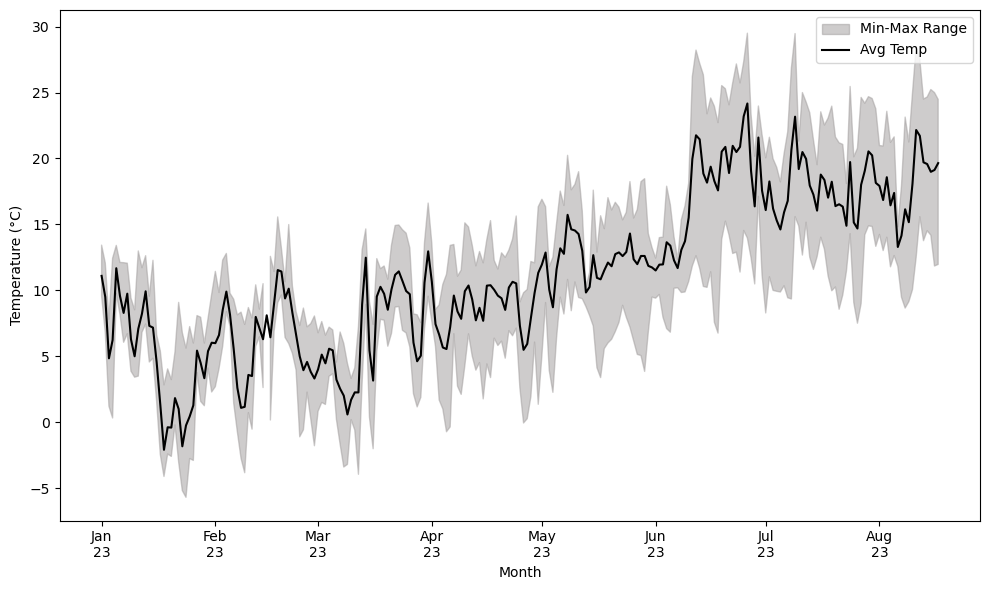

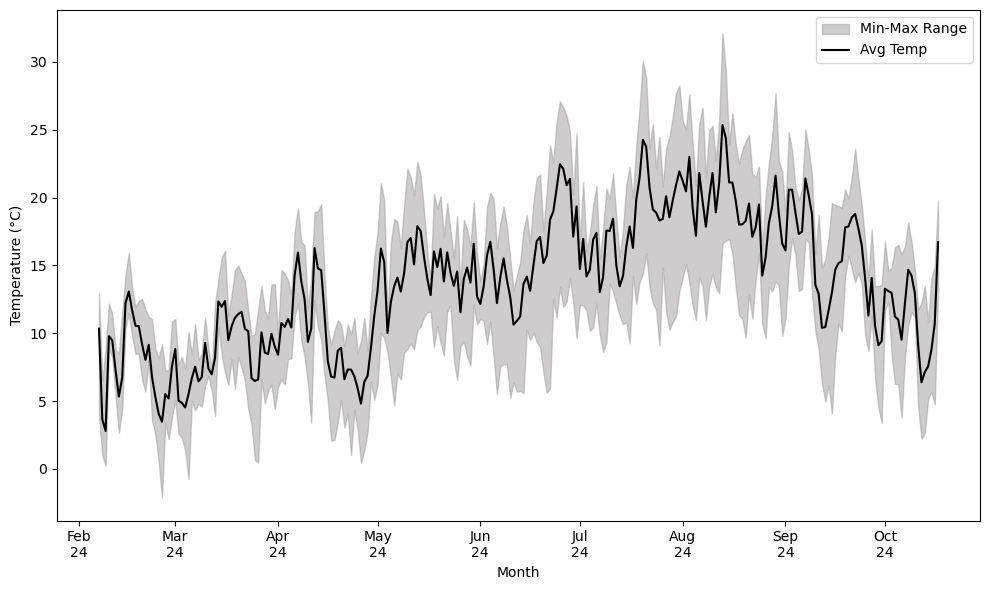

In [12]:
def plot_daily_temperature(experiment):
    # Filter and prepare data
    df = daily_filtered[experiment]
    df = df.sort_values('date_time')  # Ensure dates are sorted

    fig, ax = plt.subplots(figsize=(10, 6))

    # Shaded area between min and max temperature
    ax.fill_between(df['date_time'], df['Min_AirTC'], df['Max_AirTC'], 
                    color="#9E9A9A", alpha=0.5, label='Min-Max Range')

    # Plot lines
    ax.plot(df['date_time'], df['PTemp_C_Avg'], color='black', label='Avg Temp')

    # X-axis formatting
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%y'))

    # Axis labels and title
    ax.set_xlabel('Month')
    ax.set_ylabel('Temperature (°C)')
    ax.tick_params(axis='x', which='minor', bottom=False)
    plt.legend()
    plt.tight_layout()

    # Save and show plot
    plt.savefig(f'../Graphs/Weather/daily_temp_{experiment}.pdf')
    plt.show()
plot_daily_temperature('all_2023')
plot_daily_temperature('all_2024')

## Hourly plots

Plotting the average of each day with SE because otherwise it's too much data over so many months. 

/var/folders/ns/9skdzql508n7rzzgbqpc2wpw000f7r/T/ipykernel_61307/3145463281.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hourly['Date'] = hourly['date_time'].dt.date  # add a column for date
/var/folders/ns/9skdzql508n7rzzgbqpc2wpw000f7r/T/ipykernel_61307/3145463281.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hourly['Date'] = pd.to_datetime(hourly['Date'])
/var/folders/ns/9skdzql508n7rzzgbqpc2wpw000f7r/T/ipykernel_61307/3145463281.py:4: SettingWithCopyWarning: 
A value is trying to be set on 

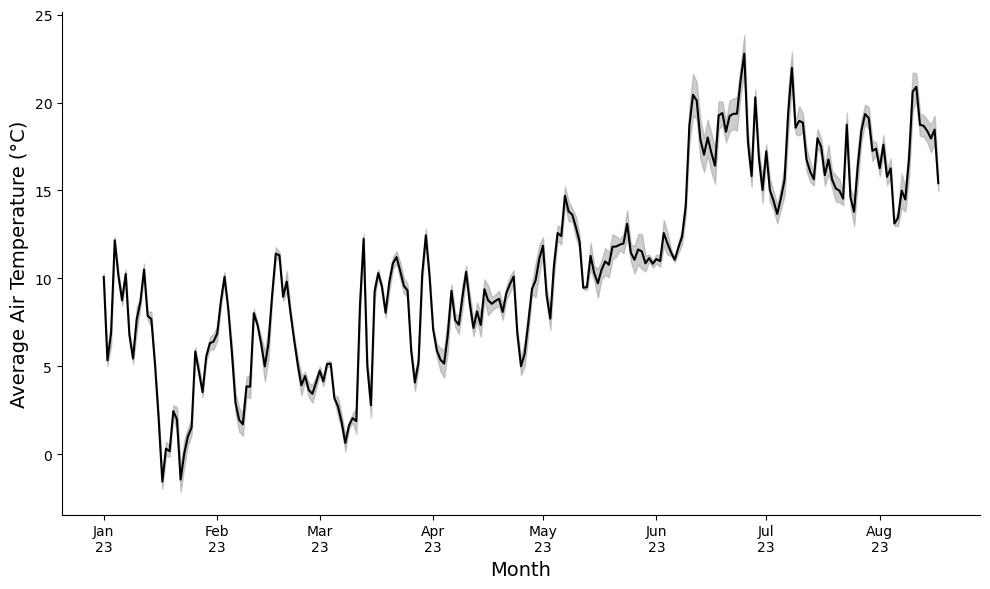

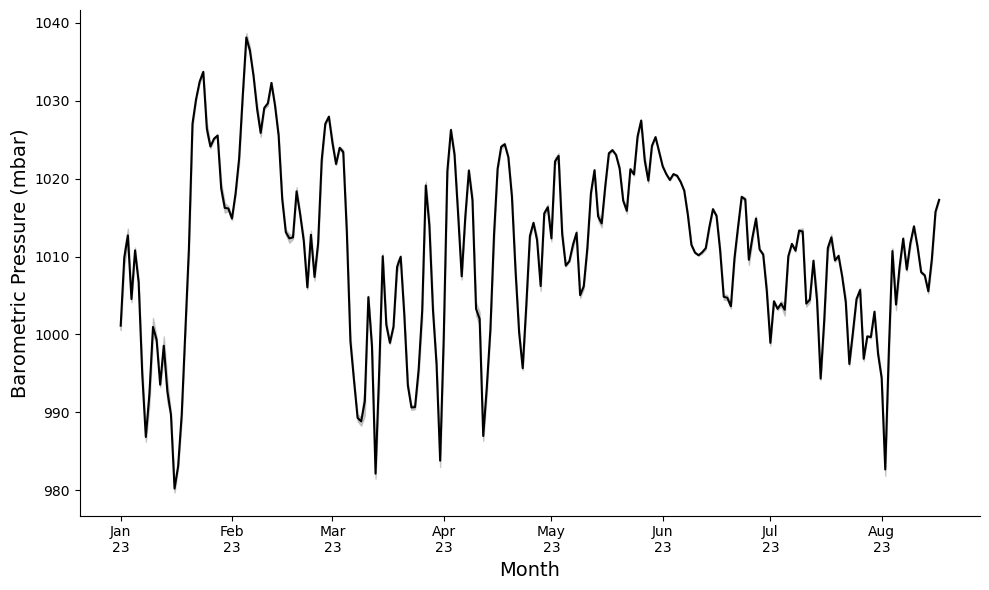

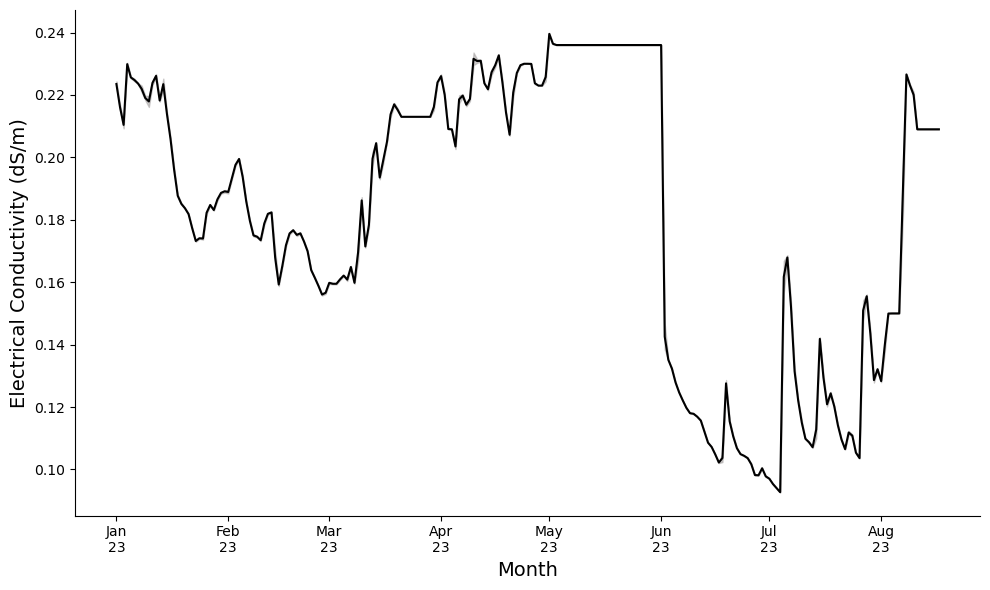

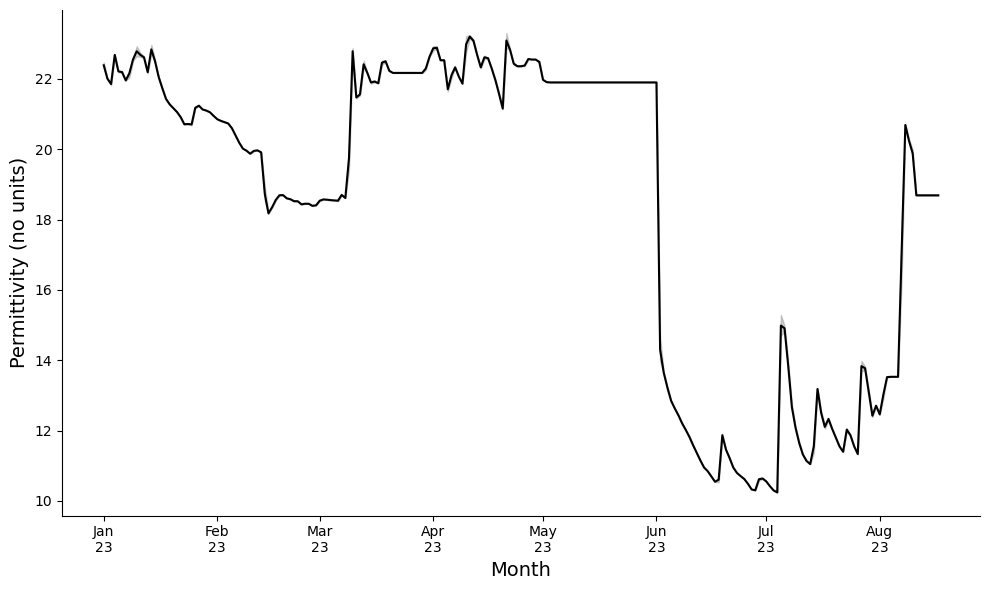

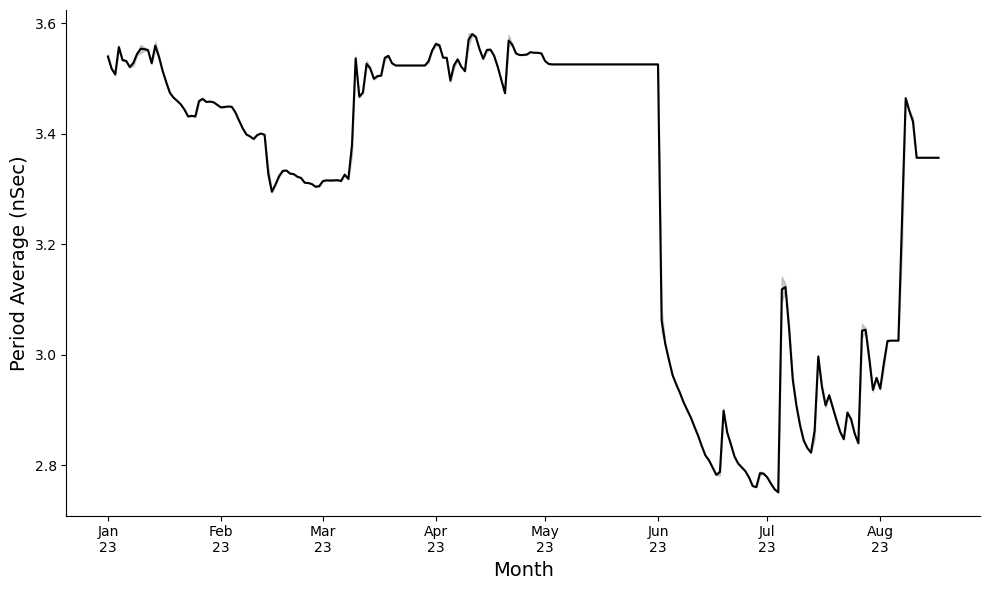

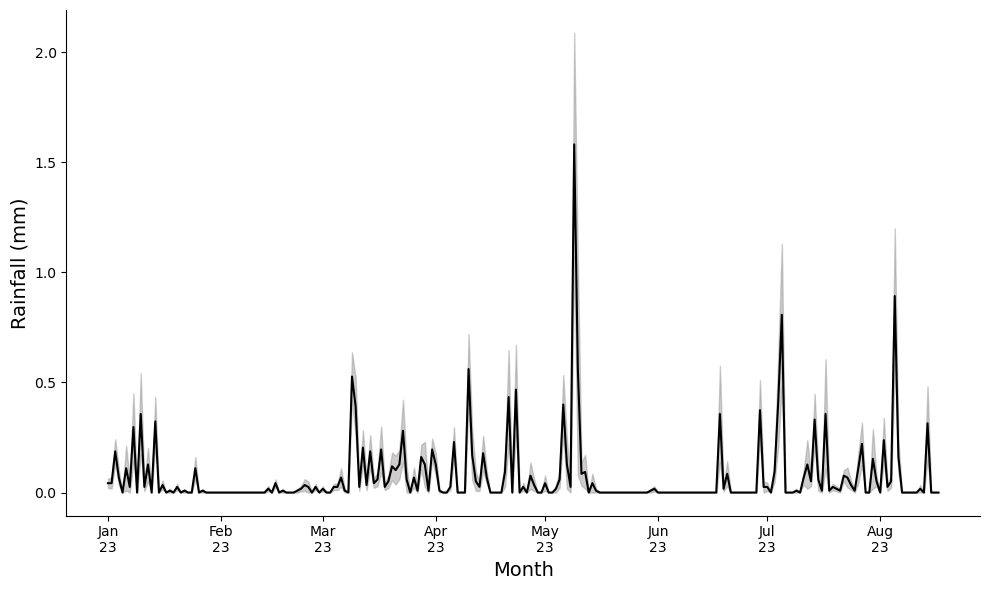

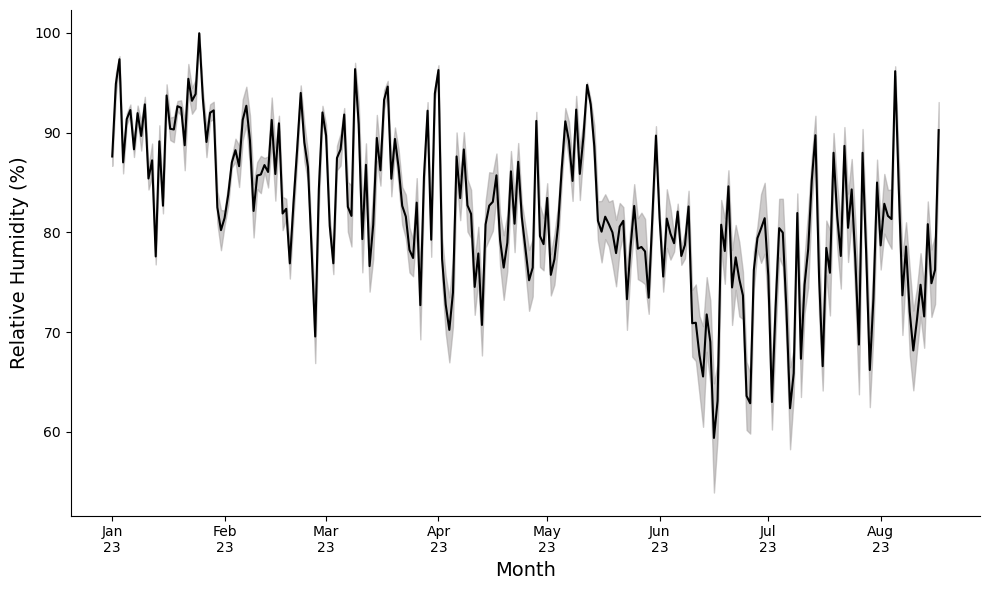

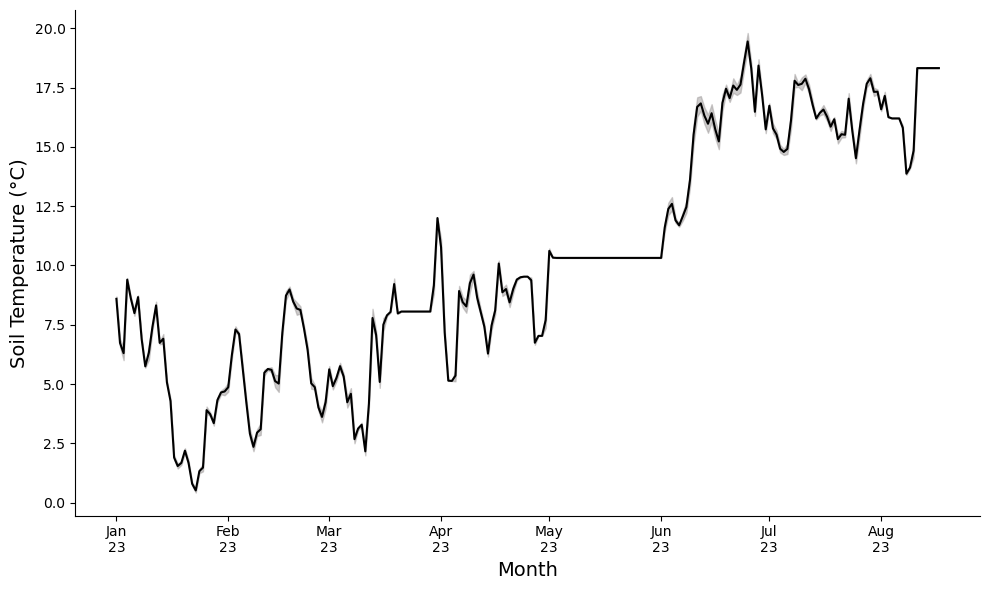

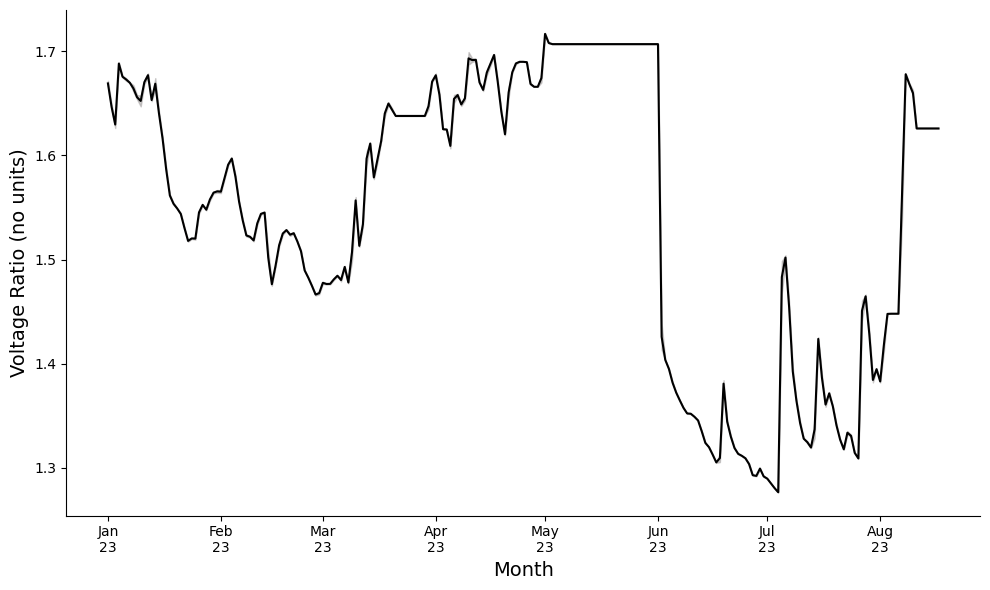

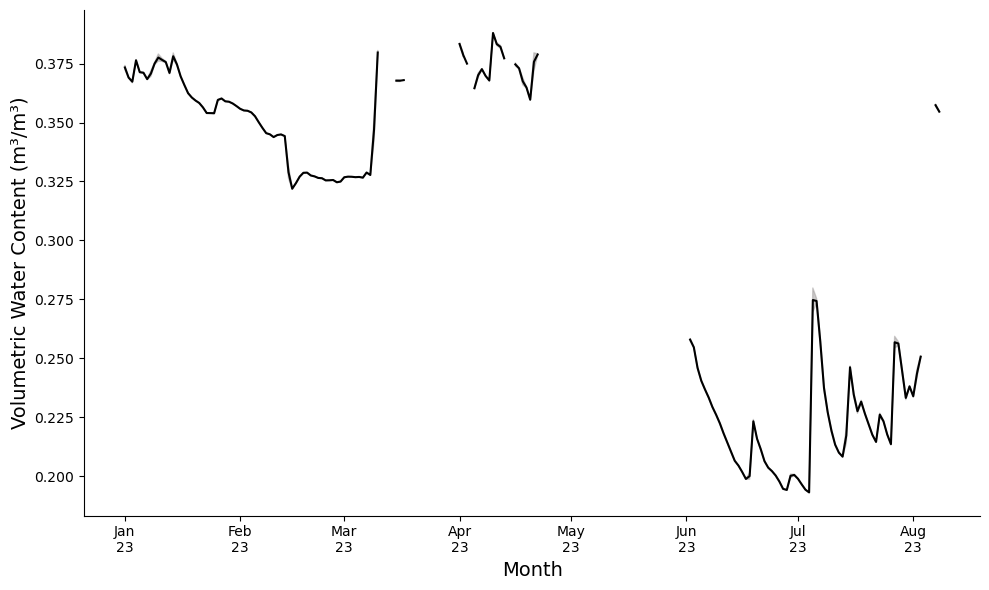

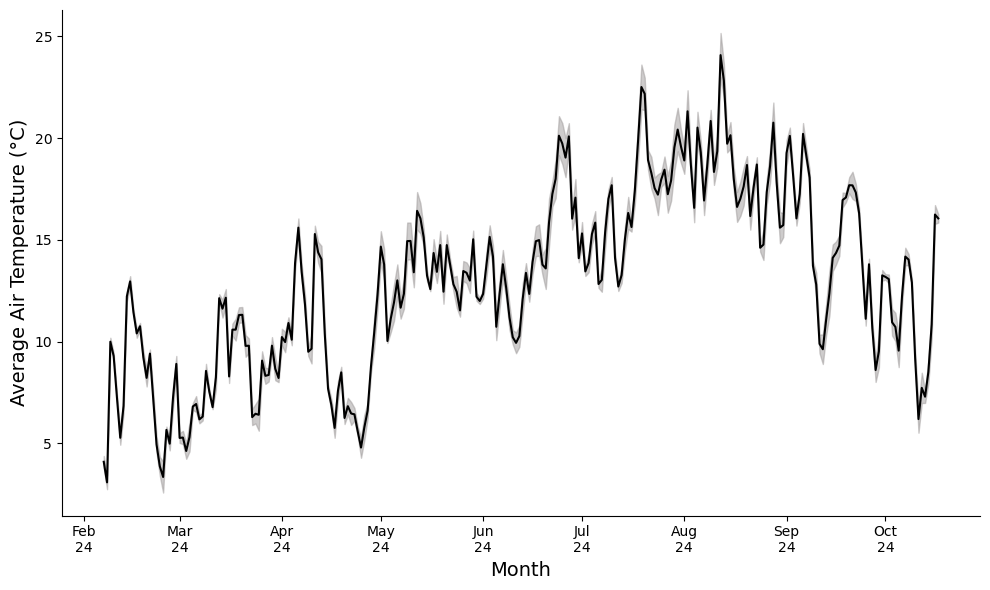

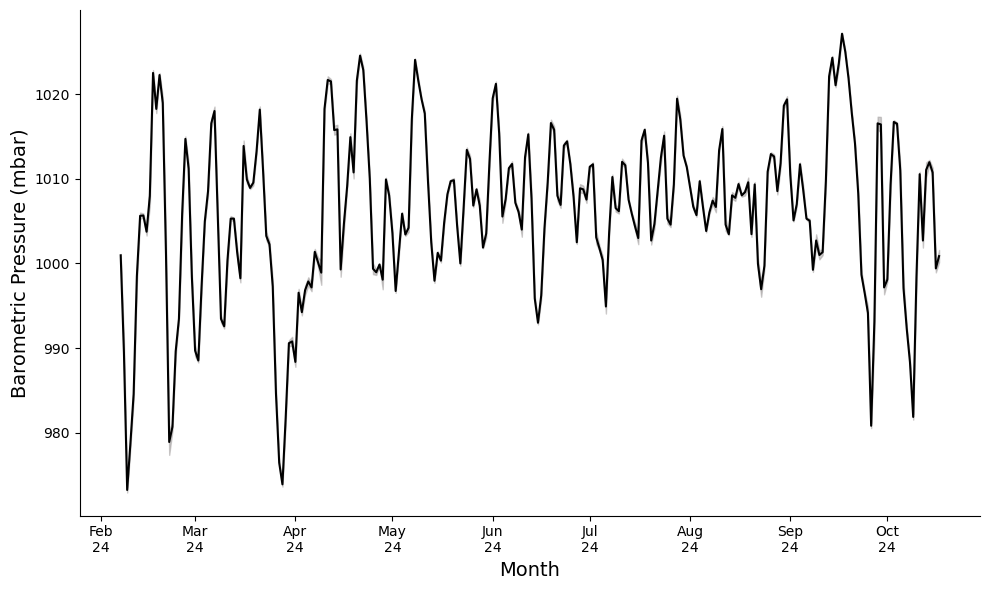

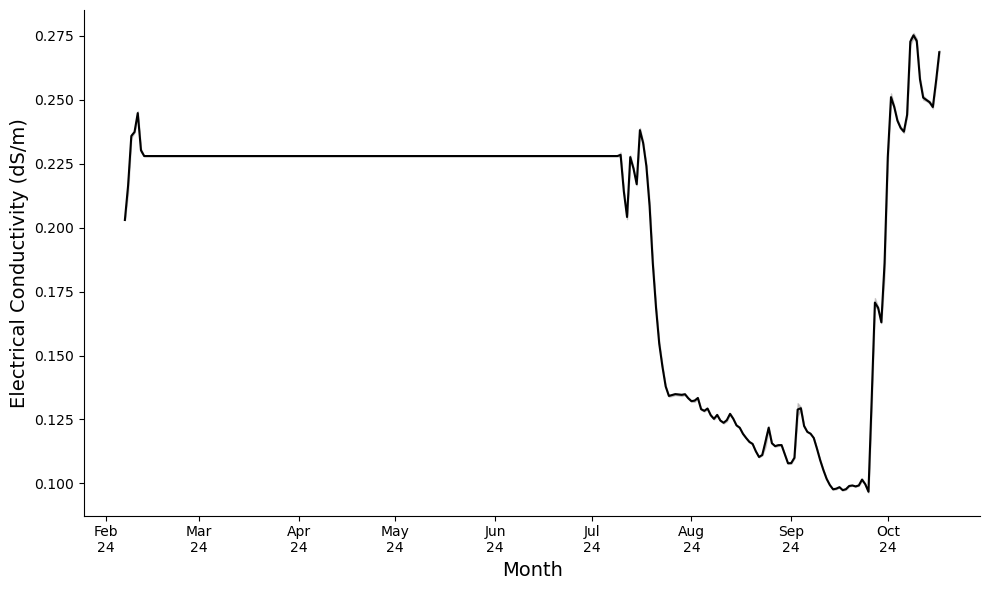

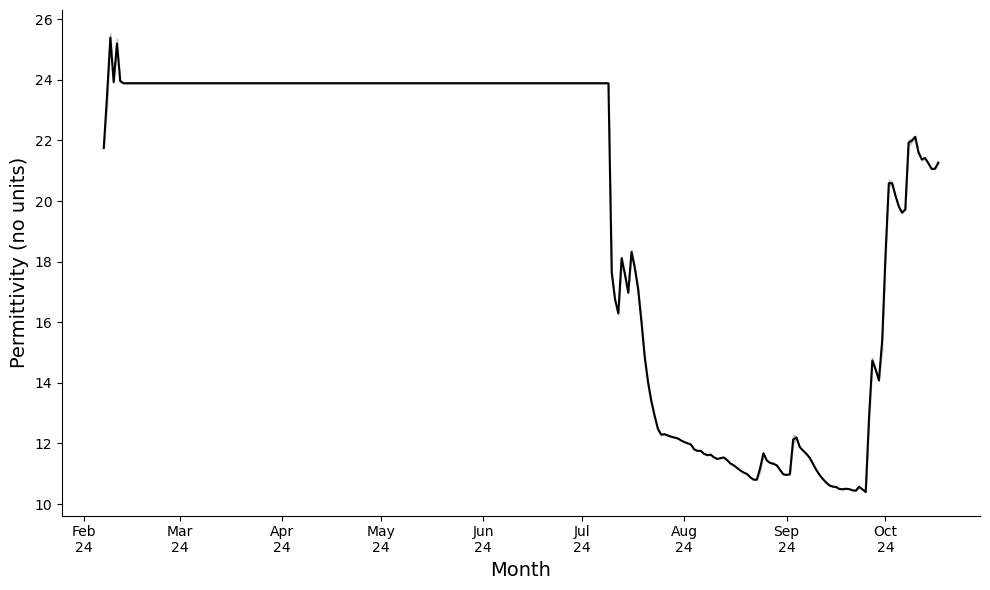

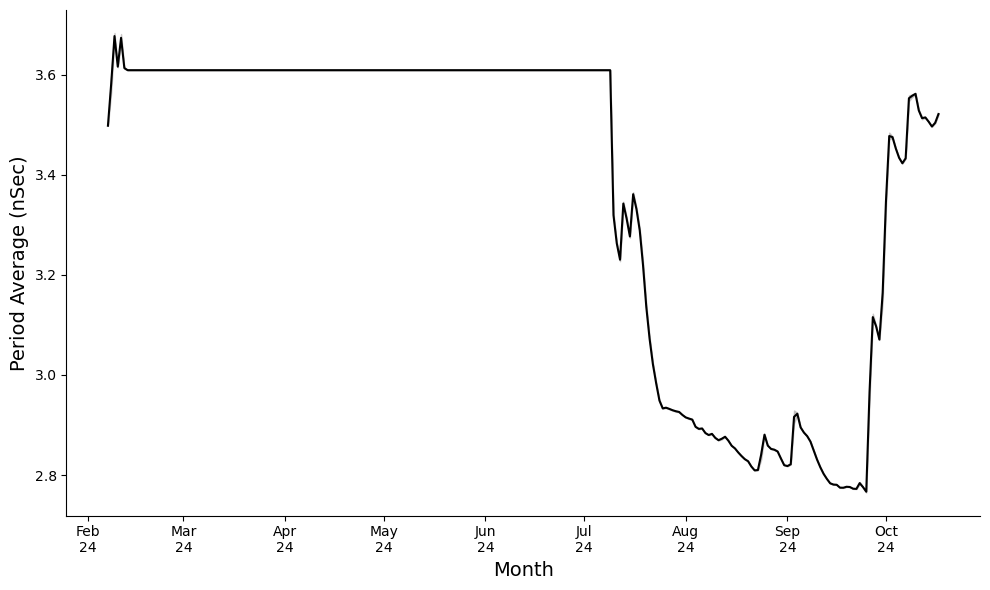

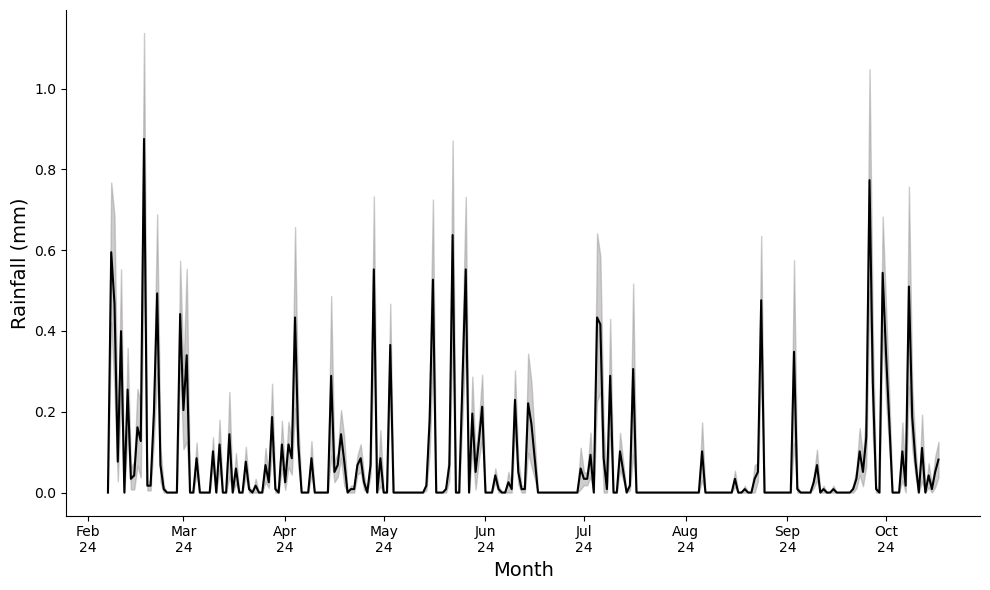

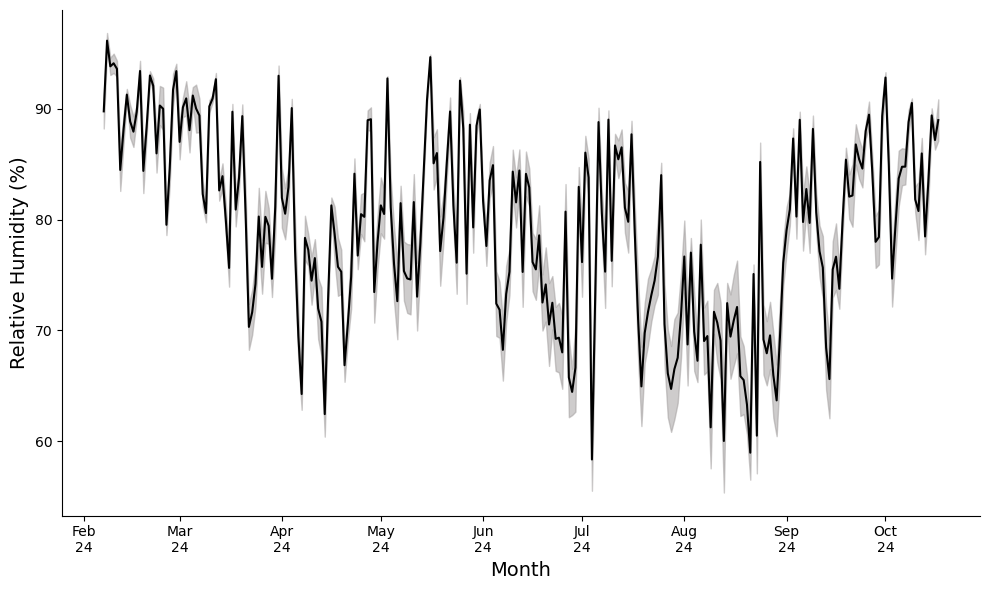

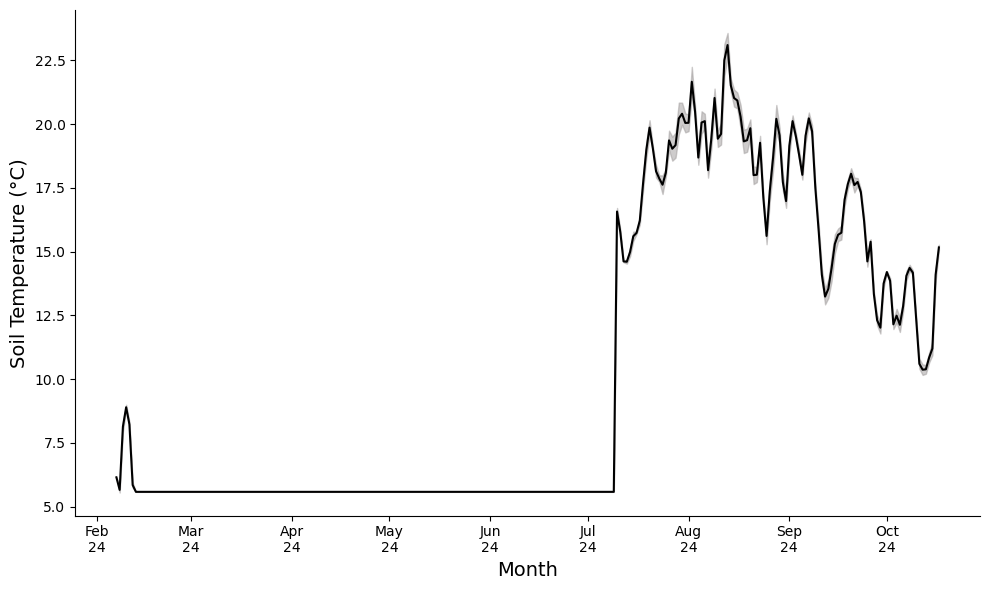

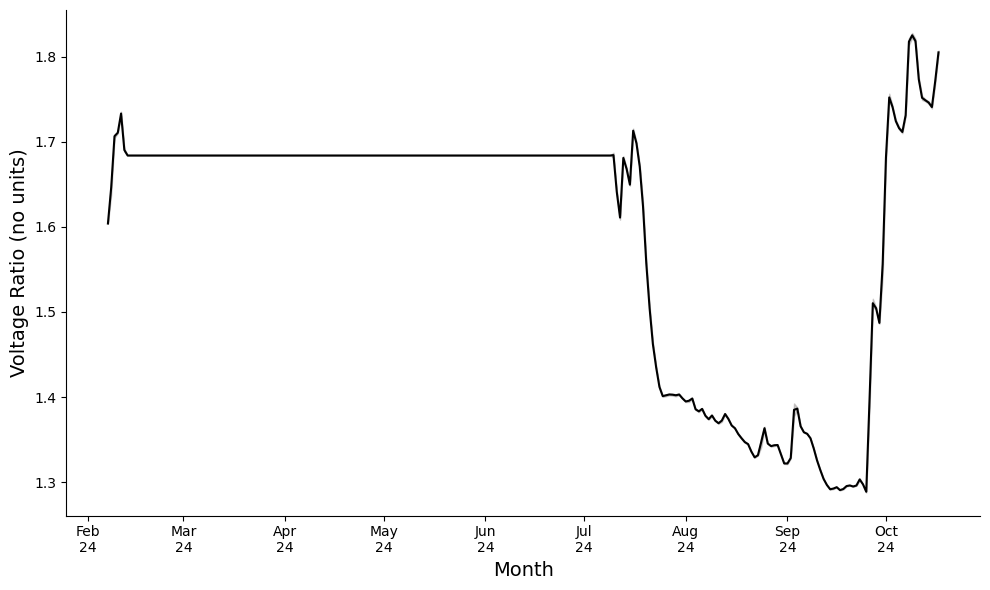

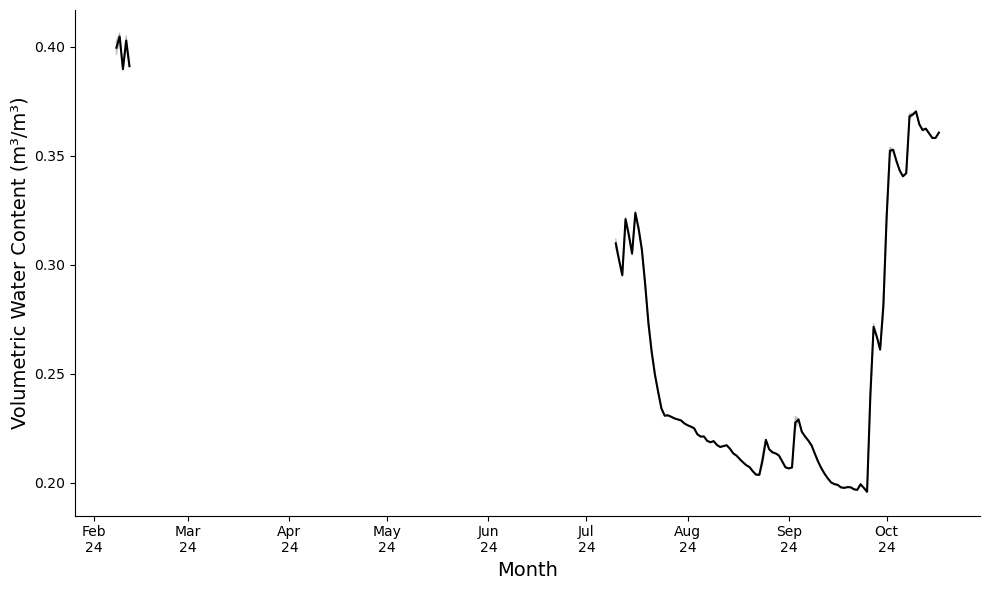

In [13]:
def plot_hourly_data(experiment, plot_title):
    hourly = hourly_filtered[experiment]

    hourly['Date'] = hourly['date_time'].dt.date  # add a column for date
    hourly['Date'] = pd.to_datetime(hourly['Date'])

    # Specify the columns you don't want to include in the aggregation
    columns_to_exclude = ['Date', 'date_time']

    # Get the list of columns you want to include in the aggregation
    columns_to_include = [col for col in hourly.columns if col not in columns_to_exclude]

    # Perform the aggregation on the selected columns
    group_hour = hourly.groupby('Date')[columns_to_include].agg(['mean', 'sem'])

    # Create a figure and axis object for each variable
    for variable in group_hour.columns.levels[0]:
        fig, ax = plt.subplots(figsize=(10, 6))

        # Plot the standard error as error bars
        # ax.errorbar(group_hour.index, group_hour[(variable, 'mean')],
        #             yerr=group_hour[(variable, 'sem')],
        #             fmt='none', ecolor="#9E9A9A", capsize=2, label='SE')

        # Set up the shaded area for standard error
        mean_series = group_hour[(variable, 'mean')]
        sem_series = group_hour[(variable, 'sem')]

        lower_bound = mean_series - sem_series
        upper_bound = mean_series + sem_series

        # Plot the shaded standard error area
        ax.fill_between(group_hour.index, lower_bound, upper_bound,
                        color="#9E9A9A", alpha=0.5, label='Standard Error Range')


        # Plot the mean line
        ax.plot(group_hour.index, group_hour[(variable, 'mean')],
                 linestyle='-', markersize=5, label=variable, color='black')

        # X-axis formatting
        ax.xaxis.set_major_locator(mdates.MonthLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%y'))

        # Nice labels
        if variable == 'AirTC_Avg':
            ylabel = 'Average Air Temperature (°C)'
            title = f'Average Air Temperature'
        elif variable == 'RH':
            ylabel = 'Relative Humidity (%)'
            title = f'Relative Humidity'
        elif variable == 'VWC_Avg':
            ylabel = 'Volumetric Water Content (m³/m³)'
            title = f'Volumetric Water Content'
        elif variable == 'EC_Avg':
            ylabel = 'Electrical Conductivity (dS/m)'
            title = f'Electrical Conductivity'
        elif variable == 'T_Avg':
            ylabel = 'Soil Temperature (°C)'
            title = f'Soil Temperature'
        elif variable == 'P_Avg':
            ylabel = 'Permittivity (no units)'
            title = f'Permittivity'
        elif variable == 'PA_Avg':
            ylabel = 'Period Average (nSec)'
            title = f'Period Average'
        elif variable == 'VR_Avg':
            ylabel = 'Voltage Ratio (no units)'
            title = f'Voltage Ratio'
        elif variable == 'Rain_mm_Tot':
            ylabel = 'Rainfall (mm)'
            title = f'Rainfall'
        elif variable == 'BP_mbar_Avg':
            ylabel = 'Barometric Pressure (mbar)'
            title = f'Barometric Pressure'
        else:
            ylabel = 'Value'
            title = f'{variable} Plot - {experiment}'

        # Set labels and title
        ax.set_xlabel('Month', fontsize=14)
        ax.set_ylabel(ylabel, fontsize=14)
        # ax.set_title(f'{title} {plot_title}', fontsize=16)

        # Add legend
        # ax.legend(fontsize=12)

        # Remove the top and right spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        # Show plot
        plt.tight_layout()
        plt.savefig(f'../Graphs/Weather/hourly_{variable}_{experiment}.pdf')

# For the data
plot_hourly_data('all_2023', 'for 2023')
plot_hourly_data('all_2024', 'for 2024')

## Look into the 10 minute data 

Currently also plotting daiy average of the 10 min data, which I think makes sense when looking over a year

/var/folders/ns/9skdzql508n7rzzgbqpc2wpw000f7r/T/ipykernel_61307/570457299.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ten_min['Date'] = ten_min['date_time'].dt.date  # add a column for date
/var/folders/ns/9skdzql508n7rzzgbqpc2wpw000f7r/T/ipykernel_61307/570457299.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ten_min['Date'] = pd.to_datetime(ten_min['Date'])


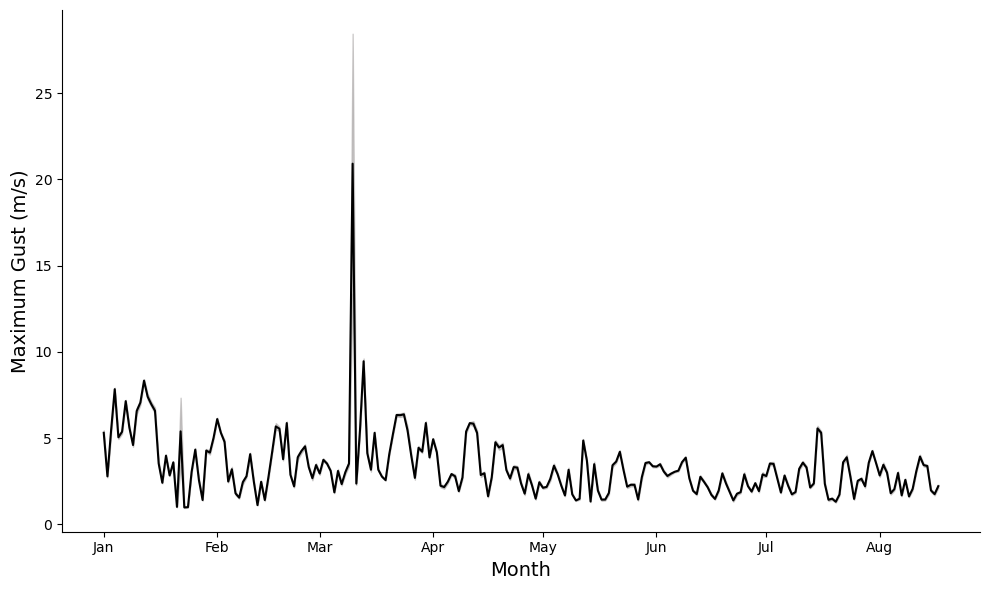

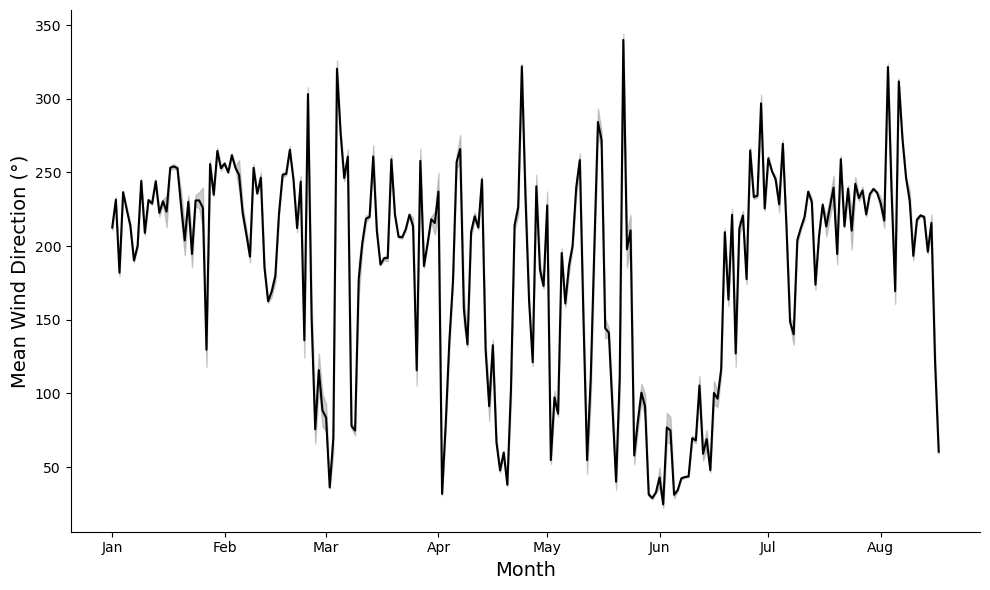

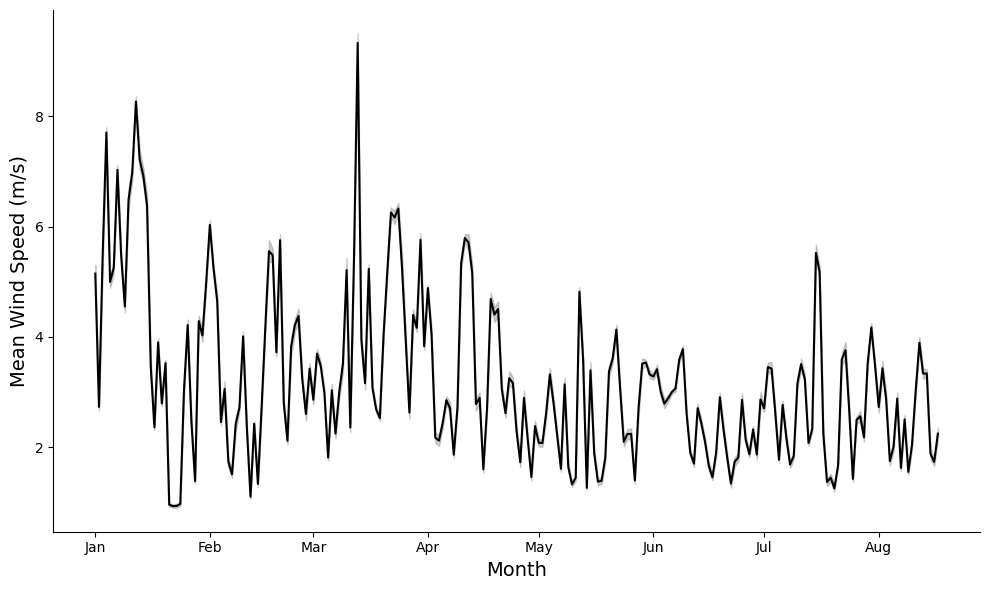

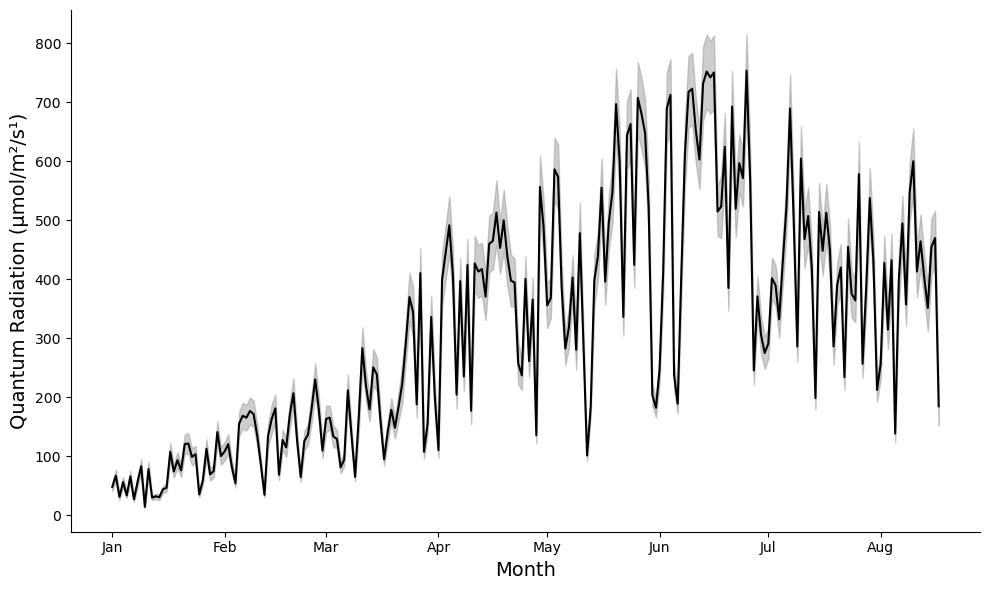

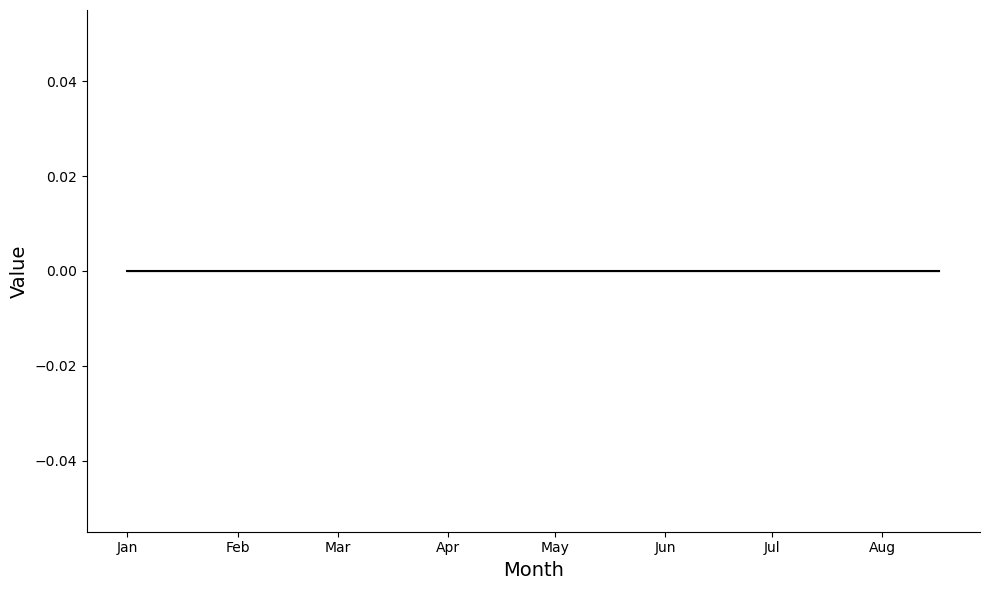

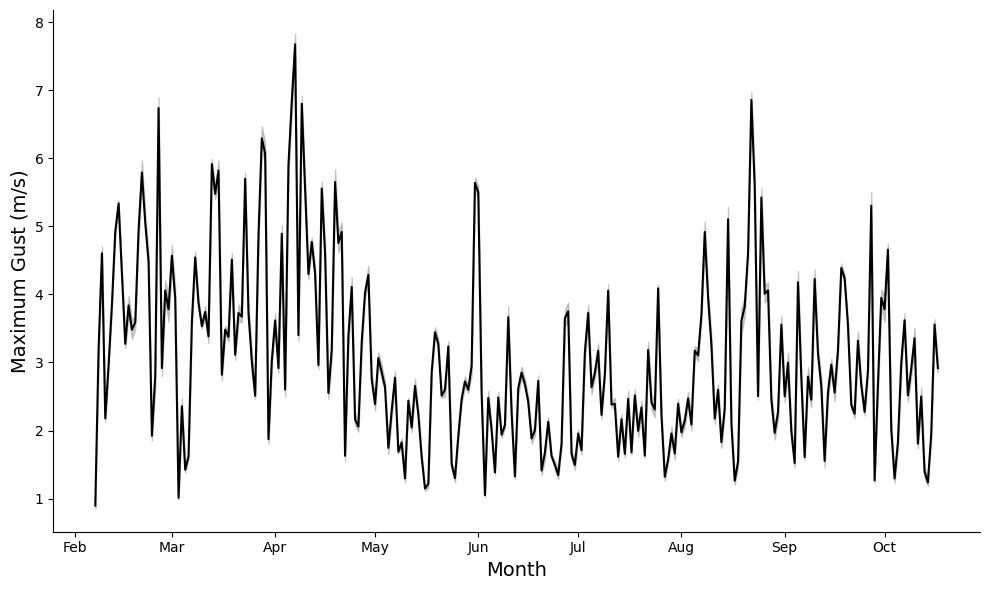

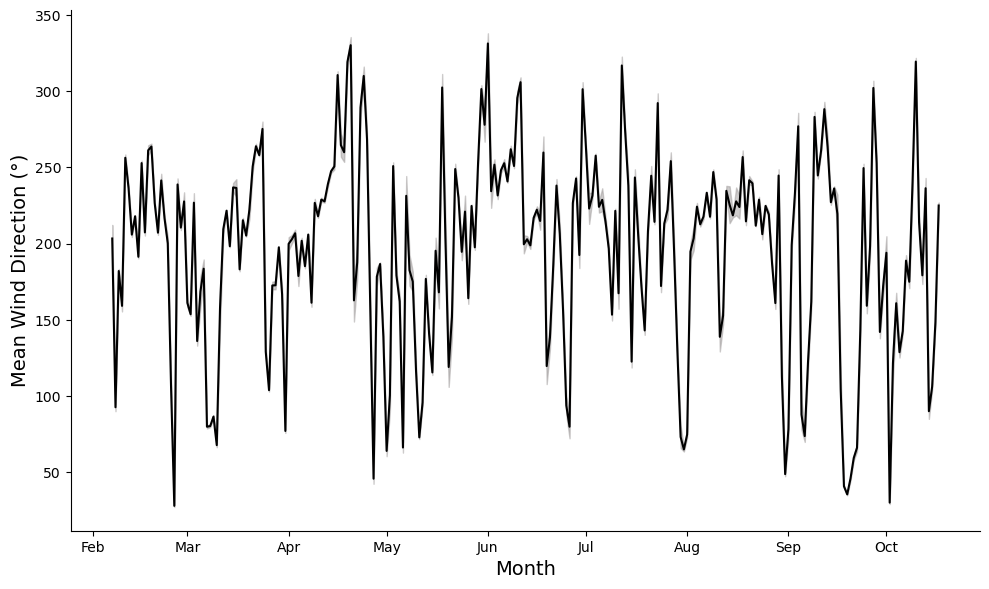

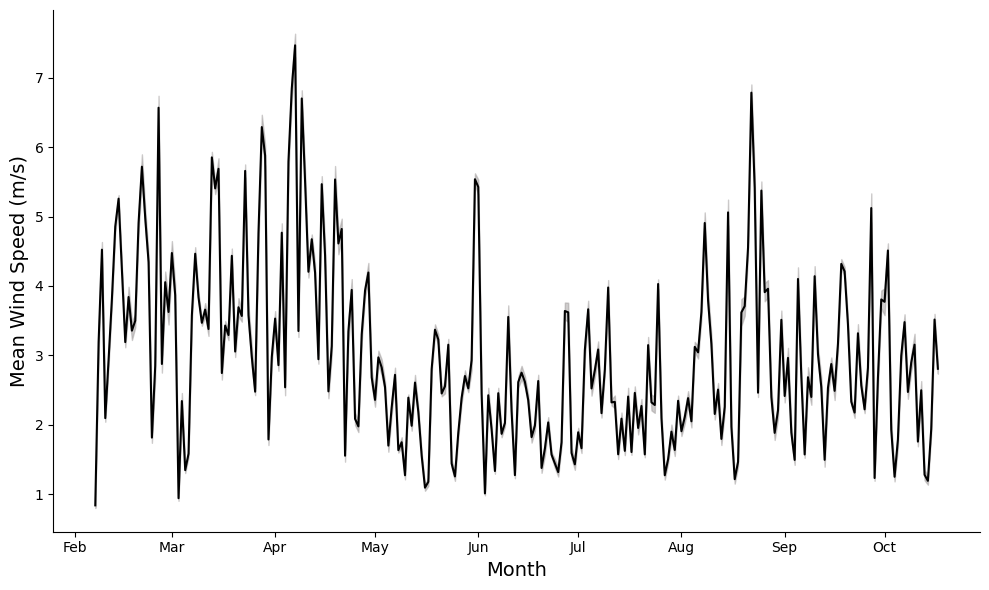

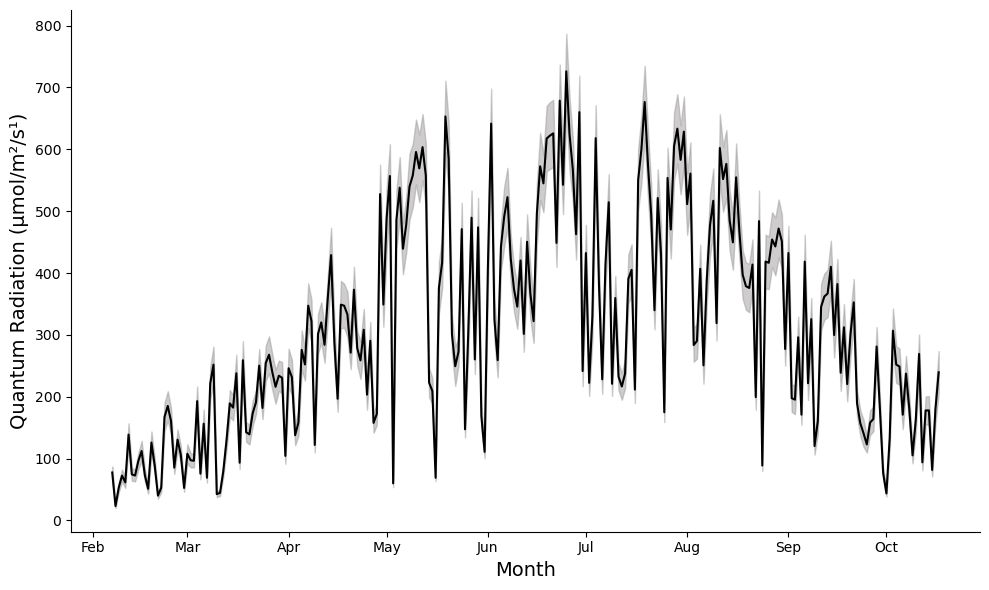

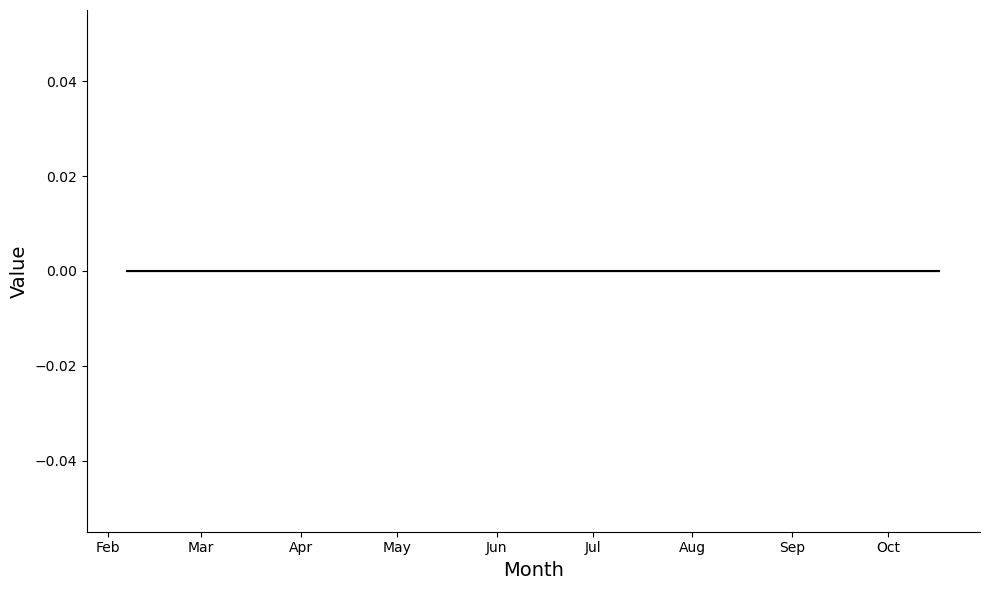

In [14]:
def plot_ten_min_data(experiment, plot_title):
    ten_min = ten_min_filtered_ws[experiment]

    ten_min['Date'] = ten_min['date_time'].dt.date  # add a column for date
    ten_min['Date'] = pd.to_datetime(ten_min['Date'])

    # Specify the columns you don't want to include in the aggregation
    columns_to_exclude = ['Date', 'date_time']

    # Get the list of columns you want to include in the aggregation
    columns_to_include = [col for col in ten_min.columns if col not in columns_to_exclude]

    # Perform the aggregation on the selected columns
    group_min = ten_min.groupby('Date')[columns_to_include].agg(['mean', 'sem'])

    # Get the first level of the column names
    variables = group_min.columns.get_level_values(0).unique()

    # Create a figure and axis object for each variable
    for variable in variables:
        fig, ax = plt.subplots(figsize=(10, 6))

        # Plot the standard error as error bars
        # ax.errorbar(group_min.index, group_min[(variable, 'mean')], yerr=group_min[(variable, 'sem')], fmt='none', ecolor='#F2A172', capsize=2, label='SE')

        # Set up the shaded area for standard error
        mean_series = group_min[(variable, 'mean')]
        sem_series = group_min[(variable, 'sem')]

        lower_bound = mean_series - sem_series
        upper_bound = mean_series + sem_series

        # Plot the shaded standard error area
        ax.fill_between(group_min.index, lower_bound, upper_bound,
                        color="#9E9A9A", alpha=0.5, label='Standard Error Range')

        # Plot the mean line
        ax.plot(group_min.index, group_min[(variable, 'mean')], linestyle='-', markersize=5, label=variable, color='black')

        # Format the x-axis to display dates nicely
        ax.xaxis.set_major_locator(mdates.MonthLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

        # Nice labels
        if variable == 'QR_Avg':
            ylabel = 'Quantum Radiation (μmol/m²/s¹)'
            title = f'Average Quantum Radiation'
        elif variable == 'Mean_WS':
            ylabel = 'Mean Wind Speed (m/s)'
            title = f'Mean Wind Speed for Wind Vector'
        elif variable == 'Mean_WD':
            ylabel = 'Mean Wind Direction (°)'
            title = f'Mean Wind Direction for Wind Vector'
        elif variable == 'Gust_Max':
            ylabel = 'Maximum Gust (m/s)'
            title = f'Maximum Gust'
        else:
            ylabel = 'Value'
            title = f'{variable}'

        # Set labels and title
        ax.set_xlabel('Month', fontsize=14)
        ax.set_ylabel(ylabel, fontsize=14)
        # ax.set_title(f'{title} {plot_title}', fontsize=16)


        # Remove the top and right spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        # Show plot
        plt.tight_layout()
        plt.savefig(f'../Graphs/Weather/ten_min_{variable}_{experiment}.pdf')
        plt.show()

# Run the function
plot_ten_min_data('all_2023', 'for 2023')
plot_ten_min_data('all_2024', 'for 2024')


# Panel plot time

In [22]:
def plot_grouped_mean_sem_data(experiment, variable, nice_label, ax, source):
    df = {'hourly': hourly_filtered, 'ten_min': ten_min_filtered_ws}[source][experiment]
    df['Date'] = pd.to_datetime(df['date_time'].dt.date)
    columns_to_exclude = ['Date', 'date_time']
    columns_to_include = [col for col in df.columns if col not in columns_to_exclude]
    group_data = df.groupby('Date')[columns_to_include].agg(['mean', 'sem'])

    if variable not in group_data.columns.levels[0]:
        return  # Skip if variable is missing

    mean_series = group_data[(variable, 'mean')]
    sem_series = group_data[(variable, 'sem')]
    lower_bound = mean_series - sem_series
    upper_bound = mean_series + sem_series

    # # Add a red line for the overall mean
    # overall_mean = df[variable].mean()
    # ax.axhline(overall_mean, color='#8B0000', linestyle='--', linewidth=0.7, label='Season Mean')

    # Plot the shaded standard error area
    ax.fill_between(group_data.index, lower_bound, upper_bound, color="#9E9A9A", alpha=0.75)
    # Plot the mean line
    ax.plot(group_data.index, mean_series, color='black', linewidth=0.8)

    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%y'))
    ax.set_xlabel('Month')
    ax.set_ylabel(nice_label)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)


In [23]:
def plot_daily_temperature_on_ax(experiment, ax):
    df = daily_filtered[experiment]
    df = df.sort_values('date_time')
    
    # Add a dark red line for the overall mean temperature
    # overall_mean_temp = df['PTemp_C_Avg'].mean()
    # ax.axhline(overall_mean_temp, color='#8B0000', linestyle='--', linewidth=0.7, label='Season Mean')

    # Shaded area between min and max temperature
    ax.fill_between(df['date_time'], df['Min_AirTC'], df['Max_AirTC'], color="#9E9A9A", alpha=0.75, label='Min-Max Range')
    
    # Plot average temperature
    ax.plot(df['date_time'], df['PTemp_C_Avg'], color='black', label='Avg Temp', linewidth=0.8)


    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%y'))
    ax.set_xlabel('Month')
    ax.set_ylabel('Temperature (°C)')
    ax.tick_params(axis='x', which='minor', bottom=False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

/var/folders/ns/9skdzql508n7rzzgbqpc2wpw000f7r/T/ipykernel_61307/3808550682.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['date_time'].dt.date)
/var/folders/ns/9skdzql508n7rzzgbqpc2wpw000f7r/T/ipykernel_61307/3808550682.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['date_time'].dt.date)
/var/folders/ns/9skdzql508n7rzzgbqpc2wpw000f7r/T/ipykernel_61307/3808550682.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

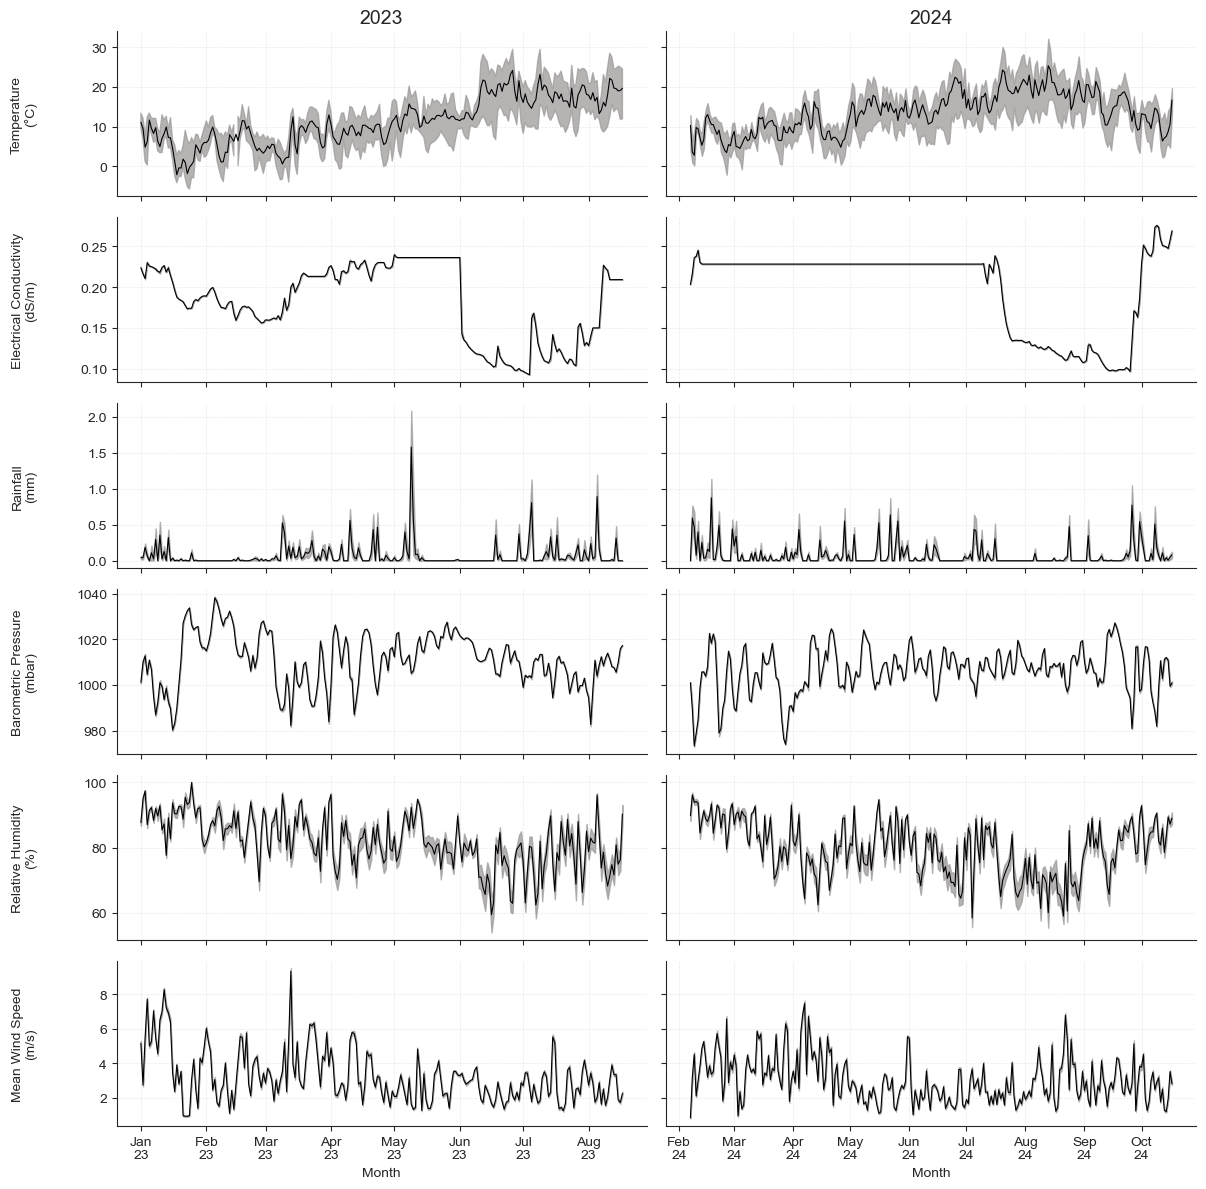

In [24]:

# Define your panel: (variable, source, nice_label)
panel_rows = [
    ('PTemp_C_Avg', 'daily', 'Temperature\n(°C)'),      # Daily temperature
    ('EC_Avg', 'hourly', 'Electrical Conductivity\n(dS/m)'),  # Hourly electrical conductivity
    ('Rain_mm_Tot', 'hourly', 'Rainfall\n(mm)'),         # Hourly rainfall
    ('BP_mbar_Avg', 'hourly', 'Barometric Pressure\n(mbar)'),  # Hourly barometric pressure
    ('RH', 'hourly', 'Relative Humidity\n(%)'),         # Hourly RH
    ('Mean_WS', 'ten_min', 'Mean Wind Speed\n(m/s)'),   # 10-min wind speed
]
years = [2023, 2024]

fig, axes = plt.subplots(len(panel_rows), len(years), figsize=(12, 12), sharex='col', sharey='row')

for row_idx, (variable, source, nice_label) in enumerate(panel_rows):
    for col_idx, year in enumerate(years):
        ax = axes[row_idx, col_idx]
        experiment = f'all_{year}'

        if source == 'daily':
            plot_daily_temperature_on_ax(experiment, ax)
        else:
            plot_grouped_mean_sem_data(experiment, variable, nice_label, ax, source)

        if row_idx == 0:
            ax.set_title(str(year), fontsize=14)
        if col_idx == 0:
            ax.set_ylabel(nice_label, fontsize=10)
            ax.yaxis.set_label_coords(-0.15, 0.5)
        else:
            ax.set_ylabel('')
        if row_idx == len(panel_rows) - 1:
            ax.set_xlabel('Month')
        else:
            ax.set_xlabel('')
            ax.set_xticklabels([])
        ax.grid(axis='both', linestyle='--', linewidth=0.5, alpha=0.4)

plt.tight_layout()

plt.savefig(f'../Graphs/panel_weather_plot_noline.pdf')

# May 2024 plot

/var/folders/ns/9skdzql508n7rzzgbqpc2wpw000f7r/T/ipykernel_61307/4282451283.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['date_time'].dt.date)
/var/folders/ns/9skdzql508n7rzzgbqpc2wpw000f7r/T/ipykernel_61307/4282451283.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['date_time'].dt.date)
/var/folders/ns/9skdzql508n7rzzgbqpc2wpw000f7r/T/ipykernel_61307/4282451283.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

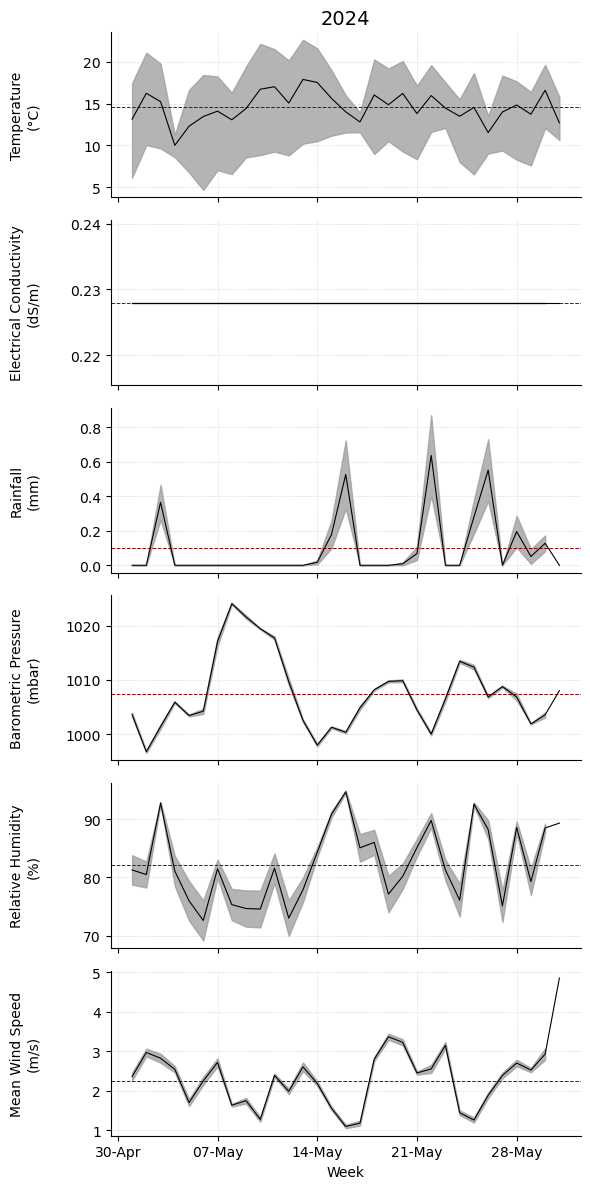

In [18]:
# Example: Plot the panel for specific collection, only for 2024

# Choose the collection name for the smaller window 
collection_name = 'may_2024' 

# Only plot for 2024
fig, axes = plt.subplots(len(panel_rows), 1, figsize=(6, 12), sharex='col', sharey='row')

for row_idx, (variable, source, nice_label) in enumerate(panel_rows):
    ax = axes[row_idx]
    experiment = collection_name

    if source == 'daily':
        plot_daily_temperature_on_ax(experiment, ax)
    else:
        plot_grouped_mean_sem_data(experiment, variable, nice_label, ax, source)

    if row_idx == 0:
        ax.set_title('2024', fontsize=14)
    ax.set_ylabel(nice_label, fontsize=10)
    ax.yaxis.set_label_coords(-0.15, 0.5)
    if row_idx == len(panel_rows) - 1:
        ax.set_xlabel('Week')
        # Set x-axis major ticks to every 7 days (weekly)
        ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
    else:
        ax.set_xlabel('')
        ax.set_xticklabels([])
    ax.grid(axis='both', linestyle='--', linewidth=0.5, alpha=0.4)

plt.tight_layout()
# plt.savefig(f'../Graphs/panel_weather_plot_{collection_name}_2024.pdf')
plt.show()

# Number of suitable days per month in each year

In [19]:
def count_suitable_days(hourly_df):
    # Ensure 'Date' column exists and is datetime
    if 'Date' not in hourly_df.columns:
        hourly_df['Date'] = pd.to_datetime(hourly_df['date_time'].dt.date)
    else:
        hourly_df['Date'] = pd.to_datetime(hourly_df['Date'])

    # Condition 1: Rainfall > 0 mm (daily total)
    rain_days = hourly_df.groupby('Date')['Rain_mm_Tot'].sum() > 0

    # Condition 2: RH > 75% (any hour in day)
    rh_days = hourly_df.groupby('Date')['RH'].max() > 75

    # Condition 3: Temp > 20°C (any hour in day)
    temp_days = hourly_df.groupby('Date')['AirTC_Avg'].max() > 20

    # Combine all into one DataFrame
    conditions_df = pd.DataFrame({
        'Temp>20': temp_days,
        'RH>75': rh_days,
        'Rain>0': rain_days
    })

    # Count number of days where all 3 conditions are met
    conditions_df['All_3'] = conditions_df.all(axis=1)

    # Convert index to datetime for grouping
    conditions_df.index = pd.to_datetime(conditions_df.index)

    monthly_counts = conditions_df.groupby(conditions_df.index.to_period('M')).sum()
    monthly_counts.index = monthly_counts.index.strftime('%b-%Y')
    return monthly_counts



In [20]:
# For each year, count the suitable days
monthly_counts_2024 = count_suitable_days(hourly_filtered['all_2024'])
monthly_counts_2023 = count_suitable_days(hourly_filtered['all_2023'])

monthly_counts = pd.concat([monthly_counts_2023, monthly_counts_2024])

/var/folders/ns/9skdzql508n7rzzgbqpc2wpw000f7r/T/ipykernel_61307/1229784699.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hourly_df['Date'] = pd.to_datetime(hourly_df['Date'])
/var/folders/ns/9skdzql508n7rzzgbqpc2wpw000f7r/T/ipykernel_61307/1229784699.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hourly_df['Date'] = pd.to_datetime(hourly_df['Date'])


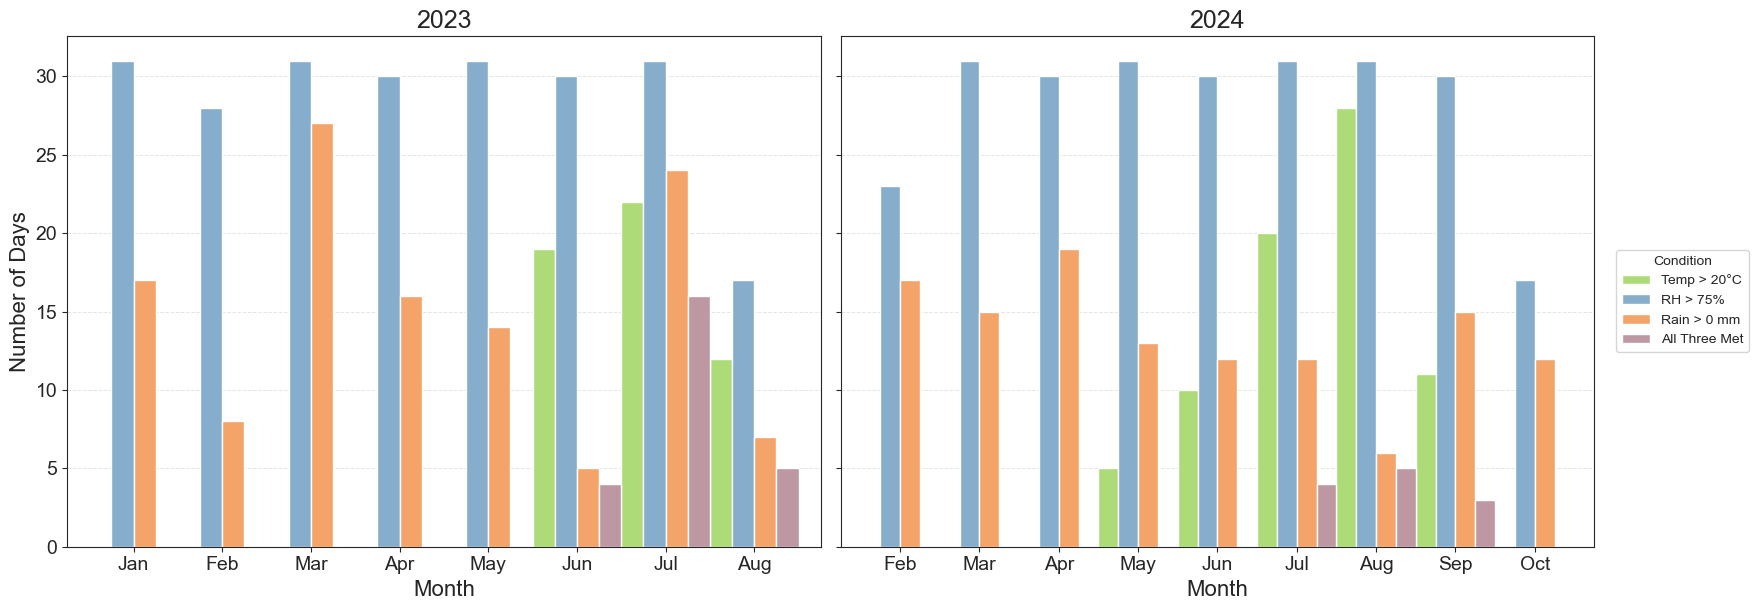

In [21]:
df = monthly_counts

sns.set_style("ticks")


# Fix index and split by year
df.index = pd.to_datetime(df.index, format='%b-%Y')
df_2023 = df[df.index.year == 2023]
df_2024 = df[df.index.year == 2024]

# Plot settings
colors = ['#ACDB78', '#87ADCC', '#F5A469', '#BD98A2']  # Nicer colours (blue, orange, green, red)
labels = ['Temp > 20°C', 'RH > 75%', 'Rain > 0 mm', 'All Three Met']

# Plot
fig, axes = plt.subplots(1, 2, sharey=True)

# Plot for 2023
df_2023.plot(kind='bar', ax=axes[0], color=colors, width=1)
axes[0].set_title("2023")
axes[0].set_ylabel("Number of Days")
axes[0].set_xlabel("Month")
axes[0].legend().remove()
axes[0].set_xticklabels(df_2023.index.strftime('%b'), rotation=0)

# Plot for 2024
df_2024.plot(kind='bar', ax=axes[1], color=colors, width=1)
axes[1].set_title("2024")
axes[1].set_ylabel("Number of Days")
axes[1].set_xlabel("Month")
axes[1].legend().remove()
axes[1].set_xticklabels(df_2024.index.strftime('%b'), rotation=0)

# Place legend outside the figure
fig.legend(labels, loc='center left', bbox_to_anchor=(1, 0.5), title="Condition")
for ax in axes:
    ax.yaxis.grid(True, color='lightgrey', linestyle='--', linewidth=0.7, alpha=0.6)
    ax.set_axisbelow(True)
    ax.set_xticks(ax.get_xticks()[::1])  # Keep all ticks, but you can skip some if you want more space
    ax.set_xticklabels(ax.get_xticklabels(), ha='center', rotation=0)
    # Increase bar width spacing by reducing the width parameter in plot(), or adjust subplot width
    for label in ax.get_xticklabels():
        label.set_horizontalalignment('center')
    # Optionally, increase figure width for more space


fig.set_figwidth(12)
# Adjust layout
plt.tight_layout()

# Save the figure with the legend outside the plot area
fig.set_figwidth(16)
fig.set_figheight(6)
plt.tight_layout()

# Increase font sizes
for ax in axes:
    ax.title.set_fontsize(18)
    ax.xaxis.label.set_fontsize(16)
    ax.yaxis.label.set_fontsize(16)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontsize(14)

# Save the figure with the legend outside the plot area
plt.savefig('../Graphs/monthly_suitable_days.pdf', bbox_inches='tight')